In [1]:
# Import libraries and set desired options
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

sns.set()
%config InlineBackend.figure_format = 'retina'

$\def\m#1{\mathbf{#1}}$
$\def\mm#1{\boldsymbol{#1}}$
$\def\mb#1{\mathbb{#1}}$
$\def\c#1{\mathcal{#1}}$
$\def\mr#1{\mathrm{#1}}$
$\newenvironment{rmat}{\left[\begin{array}{rrrrrrrrrrrrr}}{\end{array}\right]}$
$\newcommand\brm{\begin{rmat}}$
$\newcommand\erm{\end{rmat}}$
$\newenvironment{cmat}{\left[\begin{array}{ccccccccc}}{\end{array}\right]}$
$\newcommand\bcm{\begin{cmat}}$
$\newcommand\ecm{\end{cmat}}$

# Project 2
**Your group member:**

- The deadline is Mar 5th 11:59pm. Submission after the deadline will not be graded.



- This is a group projection. Your group only needs to submit one project. You can form a group of 1, 2 or 3.



- Submit your work(your reasoning and your code) as a SINGLE .ipynb document. Please rename the document as _HW1_YOURNAME.ipynb_ (for example, _HW1_FELIX.ipynb_). You are responsible for checking that you have correctly submitted the correct document. If your code cannot run, you may receive NO point.


- Please justify all short answers with a brief explanation.

- You only use the Python packages included in the following cell. You are not allowed to use other advanced package or modules unless you are permitted to.

- In your final submission include the plots produced by the unedited code as presented below, as well as any additional plots produced after editing the code during the course of a problem. You may find it necessary to copy/paste relevant code into additional cells to accomplish this.

- Feel free to use the lecture notes and other resources.


- **You must write your own code and fill in the your answer in the text box.** If you fail to do either of that, you will receive zero point.






---



---




Today we will reproduce a couple of baselines in "Intruder Detection through Webpage Session Tracking"(a.k.a. "Alice") and discuss ideas for further improvement. You'll sense the spirit of realistic datasets: brainstorming model or validation scheme improvements, adding new features, implementing new ideas in code, climbing the leaderboard – that's exciting! And that's very useful as well, especially when you're only starting your ML journey. In this assignment, we'll also work with sparse matrices (which is often the only way to work with some types of data, from the computation perspective), train Logistic Regression models, and practice feature engineering.

We have discussed in class the competition with various different methods.

In this homework, we will work through to beat these baseline. At the end, you need to come up with good features to beat leadboard!

**Problem description**

In this competition, we'll analyze the sequence of websites consequently visited by a particular person and try to predict whether this person is Alice or someone else. As a metric we will use [ROC AUC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic).

### Data Download
First, read the training and test sets. Then we'll explore the data in hand and do a couple of simple exercises.


**Data access:** the data is stored in https://drive.google.com/file/d/1WvBuXCOMho1ZAWcJLi4X-a1l-ZReG-5K/view?usp=sharing.

**Load Data:** Once you open the link in the brower, make sure you click the "Add shortcut to Drive" and now your google drive should show up the zip file.  Then you run the following code to link colab to your google drive.

### Data Description
The training data set contains the following features:

- **site1** – id of the first visited website in the session
- **time1** – visiting time for the first website in the session
- ...
- **site10** – id of the tenth visited website in the session
- **time10** – visiting time for the tenth website in the session
- **target** – target variable, 1 for Alice's sessions, and 0 for the other users' sessions
    
User sessions are chosen in the way that they are shorter than 30 min. long and contain no more than 10 websites. I.e. a session is considered over either if a user has visited 10 websites or if a session has lasted over 30 minutes.

There are some empty values in the table, it means that some sessions contain less than ten websites. Replace empty values with 0 and change columns types to integer. Also load the websites dictionary and check how it looks like:


In [2]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/My Drive/ualbany courses/ML Practicum/hw2")

Mounted at /content/drive


In [3]:
# !unzip catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2.zip

times = ["time%s" % i for i in range(1, 11)]
# customize the paths if needed
train_df = pd.read_csv("train_sessions.csv", index_col="session_id", parse_dates=times)
test_df = pd.read_csv("test_sessions.csv", index_col="session_id", parse_dates=times)

# Sort the data by time
train_df = train_df.sort_values(by="time1")

# Look at the first rows of the training set
train_df.head(3)

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0


In [4]:
print(train_df.columns)
train_df.shape

Index(['site1', 'time1', 'site2', 'time2', 'site3', 'time3', 'site4', 'time4',
       'site5', 'time5', 'site6', 'time6', 'site7', 'time7', 'site8', 'time8',
       'site9', 'time9', 'site10', 'time10', 'target'],
      dtype='object')


(253561, 21)

In [5]:
# Change site1, ..., site10 columns type to integer and fill NA-values with zeros
sites = ["site%s" % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype(np.uint16)
test_df[sites] = test_df[sites].fillna(0).astype(np.uint16)

train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55,2013-01-12 08:05:57,0,NaT,0,NaT,0,NaT,...,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0
54843,56,2013-01-12 08:37:23,55,2013-01-12 08:37:23,56,2013-01-12 09:07:07,55,2013-01-12 09:07:09,0,NaT,...,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0
77292,946,2013-01-12 08:50:13,946,2013-01-12 08:50:14,951,2013-01-12 08:50:15,946,2013-01-12 08:50:15,946,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948,2013-01-12 08:50:16,784,2013-01-12 08:50:16,949,2013-01-12 08:50:17,946,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948,2013-01-12 08:50:17,949,2013-01-12 08:50:18,948,2013-01-12 08:50:18,945,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947,2013-01-12 08:50:19,945,2013-01-12 08:50:19,946,2013-01-12 08:50:19,946,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950,2013-01-12 08:50:20,948,2013-01-12 08:50:20,947,2013-01-12 08:50:21,950,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946,2013-01-12 08:50:21,951,2013-01-12 08:50:22,946,2013-01-12 08:50:22,947,2013-01-12 08:50:22,0


In [6]:
# Load websites dictionary
with open("site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)

# Create dataframe for the dictionary
sites_dict = pd.DataFrame(
    list(site_dict.keys()), index=list(site_dict.values()), columns=["site"]
)

sites_dict.head()

,site
25075,www.abmecatronique.com
13997,groups.live.com
42436,majeureliguefootball.wordpress.com
30911,cdt46.media.tourinsoft.eu
8104,www.hdwallpapers.eu



Before we start training models, we have to perform Exploratory Data Analysis ([EDA](https://en.wikipedia.org/wiki/Exploratory_data_analysis)). Today, we are going to perform a shorter version, but we will use other techniques as we move forward. Let's check which websites in the training data set are the most visited. As you can see, they are Google services and a bioinformatics website (a website with 'zero'-index is our missed values, just ignore it):

In [7]:
# Top websites in the training data set
top_sites = (
    pd.Series(train_df[sites].values.flatten())
    .value_counts()
    .sort_values(ascending=False)
    .head(20)
)
# print(top_sites)
sites_dict.loc[top_sites.drop(0).index]

,site
21,www.google.fr
23,www.google.com
782,annotathon.org
22,apis.google.com
29,www.facebook.com
167,www.bing.com
780,blast.ncbi.nlm.nih.gov
778,www.ncbi.nlm.nih.gov
52,clients1.google.com
812,mail.google.com


In [8]:
print(top_sites.shape)
print(sites_dict.shape)

(20,)
(48371, 1)




---


Now let us look at the timestamps and try to characterize sessions as timeframes:

In [9]:
# Create a separate dataframe where we will work with timestamps
time_df = pd.DataFrame(index=train_df.index)
time_df["target"] = train_df["target"]

# Find sessions' starting and ending
time_df["min"] = train_df[times].min(axis=1)
time_df["max"] = train_df[times].max(axis=1)

# Calculate sessions' duration in seconds
time_df["seconds"] = (time_df["max"] - time_df["min"]) / np.timedelta64(1, "s")

time_df.head()

,target,min,max,seconds
session_id,,,,
21669,0,2013-01-12 08:05:57,2013-01-12 08:05:57,0.0
54843,0,2013-01-12 08:37:23,2013-01-12 09:07:09,1786.0
77292,0,2013-01-12 08:50:13,2013-01-12 08:50:17,4.0
114021,0,2013-01-12 08:50:17,2013-01-12 08:50:20,3.0
146670,0,2013-01-12 08:50:20,2013-01-12 08:50:22,2.0



In the next question, we are using the notion of "approximately the same". To be strict, let's define it: $a$ is approximately the same as $b$ ($a \approx b $) if their difference is less than or equal to 5% of the maximum between $a$ and $b$, i.e. $a \approx b \leftrightarrow \frac{|a-b|}{max(a,b)} \leq 0.05$.



---



---
# Q1:  User Identification with Logistic Regression (60pt)

## Q1.1: Brief Exploratory Data Analysis (10pt)
- What kind of websites does Alice visit the most?

- On average, is Alice's session shorter than that of other users

- What percentage of all sessions belong to Alice?

- Are minimum and maximum durations of Alice's and other users' sessions approximately the same?

- Is standard deviation of Alice's sessions duration approximately the same as for non-Alice's sessions




In [79]:
# your code starts here

# Bullet 1
alice_train_df = train_df[train_df['target'] == 1]
alice_top_sites = (
    pd.Series(alice_train_df[sites].values.flatten())
    .value_counts()
    .sort_values(ascending=False)
    .head(10)
)
print(alice_top_sites)
sites_dict.loc[alice_top_sites.index]

77     1382
80     1354
76     1307
29      897
21      857
81      609
22      522
879     522
75      451
82      447
Name: count, dtype: int64


,site
77,i1.ytimg.com
80,s.youtube.com
76,www.youtube.com
29,www.facebook.com
21,www.google.fr
81,r4---sn-gxo5uxg-jqbe.googlevideo.com
22,apis.google.com
879,r1---sn-gxo5uxg-jqbe.googlevideo.com
75,s.ytimg.com
82,r2---sn-gxo5uxg-jqbe.googlevideo.com


In [11]:
# Bullet 2
alice_time = time_df[time_df['target']==1]['seconds']
alice_time_avg = alice_time.mean()
non_alice_time_avg = time_df[time_df['target'] == 0]['seconds'].mean()
time_avg = time_df['seconds'].mean()

print("Alice's average session length: ", alice_time_avg)
print("Non-Alice's average session length: ", non_alice_time_avg)
print("Average session length: ", time_avg)

Alice's average session length:  52.29647366129734
Non-Alice's average session length:  139.28237232552215
Average session length:  138.4943701909994


In [12]:
# Bullet 3
print(f"The percent of sessions Alice was the user is {100*alice_train_df.shape[0]/train_df.shape[0]}%")

The percent of sessions Alice was the user is 0.905896411514389%


In [13]:
top_ten_longest = time_df.sort_values(by="seconds", ascending=False)[0:10]['seconds']
top_ten_shortest= time_df.sort_values(by="seconds", ascending=True)[0:10]['seconds']

atmax = alice_time.sort_values(ascending=False)[0:10]
atmin = alice_time.sort_values(ascending=True)[0:10]

print(f"Top Ten Longest Sessions: \n{top_ten_longest}")
print(f"Top Ten Shortest Sessions: \n{top_ten_shortest}")
print(f"Alice's Top Ten Longest Sessions: \n{atmax}")
print(f"Alice's Top Ten Shortest Sessions: \n{atmin}")


Top Ten Longest Sessions: 
session_id
136257    1800.0
43430     1800.0
22927     1800.0
94805     1800.0
243589    1800.0
172122    1800.0
191984    1800.0
181359    1800.0
232756    1800.0
58073     1800.0
Name: seconds, dtype: float64
Top Ten Shortest Sessions: 
session_id
21669     0.0
233905    0.0
58117     0.0
227389    0.0
38386     0.0
126210    0.0
186687    0.0
27620     0.0
233439    0.0
142193    0.0
Name: seconds, dtype: float64
Alice's Top Ten Longest Sessions: 
session_id
241510    1763.0
77982     1730.0
98482     1716.0
143257    1639.0
143962    1621.0
116907    1599.0
145869    1522.0
180193    1493.0
147417    1475.0
62801     1344.0
Name: seconds, dtype: float64
Alice's Top Ten Shortest Sessions: 
session_id
101116    0.0
246586    0.0
48768     0.0
139875    0.0
118404    0.0
46404     0.0
116578    0.0
131027    0.0
128816    0.0
168985    0.0
Name: seconds, dtype: float64


In [14]:
# Bullet 4 + 5
print(alice_time.describe())
print(time_df['seconds'].describe())

print(f"Alice Max Length Session appx equal?: {(time_df['seconds'].max()-alice_time.max())/max(time_df['seconds'].max(),alice_time.max())<=.05}")
print(f"Alice std appx equal?: {(time_df['seconds'].std()-alice_time.std())/max(time_df['seconds'].std(),alice_time.std()) <= .05}")
print((time_df['seconds'].std()-alice_time.std())/max(time_df['seconds'].std(),alice_time.std()))

count    2297.000000
mean       52.296474
std       153.309014
min         0.000000
25%         4.000000
50%        11.000000
75%        38.000000
max      1763.000000
Name: seconds, dtype: float64
count    253561.000000
mean        138.494370
std         295.781742
min           0.000000
25%           7.000000
50%          27.000000
75%         113.000000
max        1800.000000
Name: seconds, dtype: float64
Alice Max Length Session appx equal?: True
Alice std appx equal?: False
0.481681955708096


### **Discuss your findings**:


* In Alice's top 20 sites are plenty of Google properties (youtube, search engine, etc), as well as twitter and facebook. There appear to be a lot of "googlevideo" sites, likely transitionary sites youtube uses for their videos, but I'm not entirely sure. Her most visited site leads to just a static image of youtube's loading screen..

* Alice's sessions are less than half the average of all other users, with her average session being 52.3 seconds, while the average of all other sessions is 139.3 seconds (total average is 138.5 seconds)

* Alice holds less than 1% of all sessions at .9%.

* Looking at the top ten longest and shortest sessions of the dataset, we see that they are at the bounds of what is allowed (0 second and 1800 second (30 minute) sessions). Since Alice's top shortest sessions are also 0 seconds, we can say more than approximately equal, as they are actually equal. Doing the above calculation for Alice's max length session, we get $.02 \leq .05$, so her longest session is approximately equal to the max dataset session length.

* The standard deviations are 295.78 for the dataset and 153.31 for Alice, giving us $(295.78-153.31)/295.78 \approx .48 \ge .05$, thus they are not approximately equal.





---



---


In order to train our first model, we need to prepare the data. First of all, exclude the target variable from the training set. Now both training and test sets have the same number of columns, therefore aggregate them into one dataframe.  Thus, all transformations will be performed simultaneously on both training and test data sets.

On the one hand, it leads to the fact that both data sets have one feature space (you don't have to worry that you forgot to transform a feature in some data sets). On the other hand, processing time will increase.
For the enormously large sets it might turn out that it is impossible to transform both data sets simultaneously (and sometimes you have to split your transformations into several stages only for train/test data set).
In our case, with this particular data set, we are going to perform all the transformations for the whole united dataframe at once, and before training the model or making predictions we will just take its appropriate part.

In [15]:
# Our target variable
y_train = train_df["target"].astype("int").values

# United dataframe of the initial data
full_df = pd.concat([train_df.drop("target", axis=1), test_df])

# Index to split the training and test data sets
idx_split = train_df.shape[0]

For the very basic model, we will use only the visited websites in the session (but we will not take into account timestamp features). The point behind this data selection is: *Alice has her favorite sites, and the more often you see these sites in the session, the higher probability that this is Alice's session, and vice versa.*

Let us prepare the data, we will take only features `site1, site2, ... , site10` from the whole dataframe. Keep in mind that the missing values are replaced with zero. Here is how the first rows of the dataframe look like:

In [16]:
# Dataframe with indices of visited websites in session
full_sites = full_df[sites]

full_sites.head(2)

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,56,55,0,0,0,0,0,0,0,0
54843,56,55,56,55,0,0,0,0,0,0


Sessions are sequences of website indices, and data in this representation is useless for machine learning method (just think, what happens if we switched all ids of all websites).


---



---


## Q1.2: Data Preparation (10pt)
According to our hypothesis (Alice has favorite websites), we need to transform this dataframe so each website has a corresponding feature (column) and its value is equal to number of this website visits in the session.

For the work with such matrices you can use `csr_matrix` function, check [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html) to understand what possible types of sparse matrices are, how to work with them and in which cases their usage is most effective.

In [17]:
'''
# your code
# I wanted to use this, but I wasn't getting a convergence for tuning C

site_features = np.zeros((full_sites.shape[0], sites_dict.shape[0]), dtype=np.uint16)

row_num = 0
for index, row in full_sites.iterrows():
    for site in sites:
        if row[site] == 0:
            break
        site_features[row_num, row[site]-1] += 1
    row_num += 1


site_features = pd.DataFrame(site_features, columns=sites_dict['site'], index=full_sites.index)

site_features_csr = csr_matrix(site_features)

X_train = site_features_csr[:idx_split]
X_test = site_features_csr[idx_split:]

print(X_train.shape)
print(X_test.shape)
'''

"\n# your code\n# I wanted to use this, but I wasn't getting a convergence for tuning C\n\nsite_features = np.zeros((full_sites.shape[0], sites_dict.shape[0]), dtype=np.uint16)\n\nrow_num = 0\nfor index, row in full_sites.iterrows():\n    for site in sites:\n        if row[site] == 0:\n            break\n        site_features[row_num, row[site]-1] += 1\n    row_num += 1\n\n\nsite_features = pd.DataFrame(site_features, columns=sites_dict['site'], index=full_sites.index)\n\nsite_features_csr = csr_matrix(site_features)\n\nX_train = site_features_csr[:idx_split]\nX_test = site_features_csr[idx_split:]\n\nprint(X_train.shape)\nprint(X_test.shape)\n"

In [18]:

# your code
id2site = {v:k for (k, v) in site_dict.items()}

# replacing all 0's in the rows with unknown
id2site[0] = 'unknown'

# each session is represented as 1 string (as done in class, but)
train_sessions = train_df[sites].apply(lambda row: ' '.join([id2site[i] for i in row]), axis=1).tolist()
test_sessions = test_df[sites].apply(lambda row: ' '.join([id2site[i] for i in row]), axis=1).tolist()

vectorizer_params={'max_features': 50000, 'tokenizer': lambda s: s.split()}
vectorizer = TfidfVectorizer(**vectorizer_params)
X_train = vectorizer.fit_transform(train_sessions)
X_test = vectorizer.transform(test_sessions)


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [19]:
print(X_train.shape)

(253561, 41602)


In [20]:
time_test = pd.DataFrame(index=test_df.index)
time_test["min"] = test_df[times].min(axis=1)
time_test["max"] = test_df[times].max(axis=1)
time_test["seconds"] = (time_test["max"] - time_test["min"]) / np.timedelta64(1, "s")

time_test.head()

,min,max,seconds
session_id,,,
1,2014-10-04 11:19:53,2014-10-04 11:20:00,7.0
2,2014-07-03 11:00:28,2014-07-03 11:01:53,85.0
3,2014-12-05 15:55:12,2014-12-05 15:56:36,84.0
4,2014-11-04 10:03:19,2014-11-04 10:03:23,4.0
5,2014-05-16 15:05:31,2014-05-16 15:05:44,13.0




---





---



## Q1.3: First Try: Logistic Regression (10pt)
Let us build our first model, using [logistic regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) implementation from ` Sklearn` with default parameters. We will use the first 90% of the data for training (the training data set is sorted by time), and the remaining 10% for validation.

- Let's write a simple function that returns the quality of the model and then train our first classifier. What is the result on the validation set? You will need to use it in the later questions.

- To make a prediction on the test data set **we need to train the model again on the entire training data set** (until this moment, our model used only part of the data for training), which will increase its generalizing ability. You don't need to calculate the score for testing set since there is no target value.


In [153]:

def get_auc_lr_valid( X, y, C=1.0, seed=17, splits=10, scoring='roc_auc'):

    time_split = TimeSeriesSplit(n_splits=splits)
    [(el[0].shape, el[1].shape) for el in time_split.split(X)]
    model = LogisticRegression(C=C, random_state=seed, solver='liblinear')
    cv_scores = cross_val_score(model, X, y, cv=time_split, scoring='roc_auc', n_jobs=1)
    return model, cv_scores


def train_and_predict(X_train, y_train, X_test, C=1, seed=17, cv=10, scoring='roc_auc'):

    model, cv_scores = get_auc_lr_valid(X_train, y_train, C=C,
                                        seed=17, splits=cv, scoring=scoring)
    print('CV scores', cv_scores)
    print('CV mean: {}, CV std: {}'.format(cv_scores.mean(), cv_scores.std()))

    model.fit(X_train, y_train)

    test_pred = model.predict_proba(X_test)[:, 1]

    return model, cv_scores


In [22]:
# your code on training

logit, scores1 = get_auc_lr_valid(X_train, y_train)

print(scores1.mean())

0.8593675921570506


In [23]:
logit, scores1 = train_and_predict(X_train, y_train, X_test)

print(scores1.mean())

CV scores [0.80868836 0.66729651 0.86026949 0.92860927 0.84374366 0.88256224
 0.89463893 0.86597867 0.91912198 0.9227668 ]
CV mean: 0.8593675921570506, CV std: 0.07342671462719691
0.8593675921570506


### **Discuss your findings**:

Using a time split with 10 splits (i.e. $.9$ ratio between training and validation at the end), the resulting score is $.859$. there is noticable variation in the scoring, getting a min max range of $\{.66, .92\}$.




---



---


## Q1.4: Second Try: Feature Engineering (10pt)
Now we are going to improve the quality of our model by engineering new features.

- Create a feature that will be a number in YYYYMM format from the date when the session was held, for example 201407 -- year 2014 and 7th month.

- Plot the graph of the number of Alice sessions versus the new feature, start_month. Discuss the result.

- In this way, we have an illustration and thoughts about the usefulness of the new feature, add it to the training sample and check the quality of the new model. What is your score on the validation set? You should find the quality of the model has decreased significantly.

- You need to apply the standarization on this new feature and train the model again. What is your score on the validation set this time?

**Hint:** the graph will be more explicit if you treat `start_month` as a categorical ordinal variable

In [24]:
# your code
def YYYYMM(ts):
    return ts.year*100 + ts.month

def start_month(ts):
    return ts.month

time_df['YYYYMM'] = time_df['min'].map(YYYYMM)

time_df.head()

,target,min,max,seconds,YYYYMM
session_id,,,,,
21669,0,2013-01-12 08:05:57,2013-01-12 08:05:57,0.0,201301
54843,0,2013-01-12 08:37:23,2013-01-12 09:07:09,1786.0,201301
77292,0,2013-01-12 08:50:13,2013-01-12 08:50:17,4.0,201301
114021,0,2013-01-12 08:50:17,2013-01-12 08:50:20,3.0,201301
146670,0,2013-01-12 08:50:20,2013-01-12 08:50:22,2.0,201301


In [25]:
alice_time_df = time_df[time_df['target'] == 1]
alice_time_df['YYYYMM'] = alice_time_df['min'].map(YYYYMM)
alice_time_df['start_month'] = alice_time_df['min'].map(start_month)
alice_time_df.head()

<ipython-input-25-3ff93e71b1c3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alice_time_df['YYYYMM'] = alice_time_df['min'].map(YYYYMM)
<ipython-input-25-3ff93e71b1c3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alice_time_df['start_month'] = alice_time_df['min'].map(start_month)


,target,min,max,seconds,YYYYMM,start_month
session_id,,,,,,
251175,1,2013-02-12 16:25:10,2013-02-12 16:32:27,437.0,201302,2
196388,1,2013-02-12 16:32:27,2013-02-12 16:32:53,26.0,201302,2
172448,1,2013-02-12 16:32:53,2013-02-12 16:33:46,53.0,201302,2
70129,1,2013-02-12 16:33:50,2013-02-12 16:33:53,3.0,201302,2
206254,1,2013-02-12 16:33:55,2013-02-12 16:34:25,30.0,201302,2


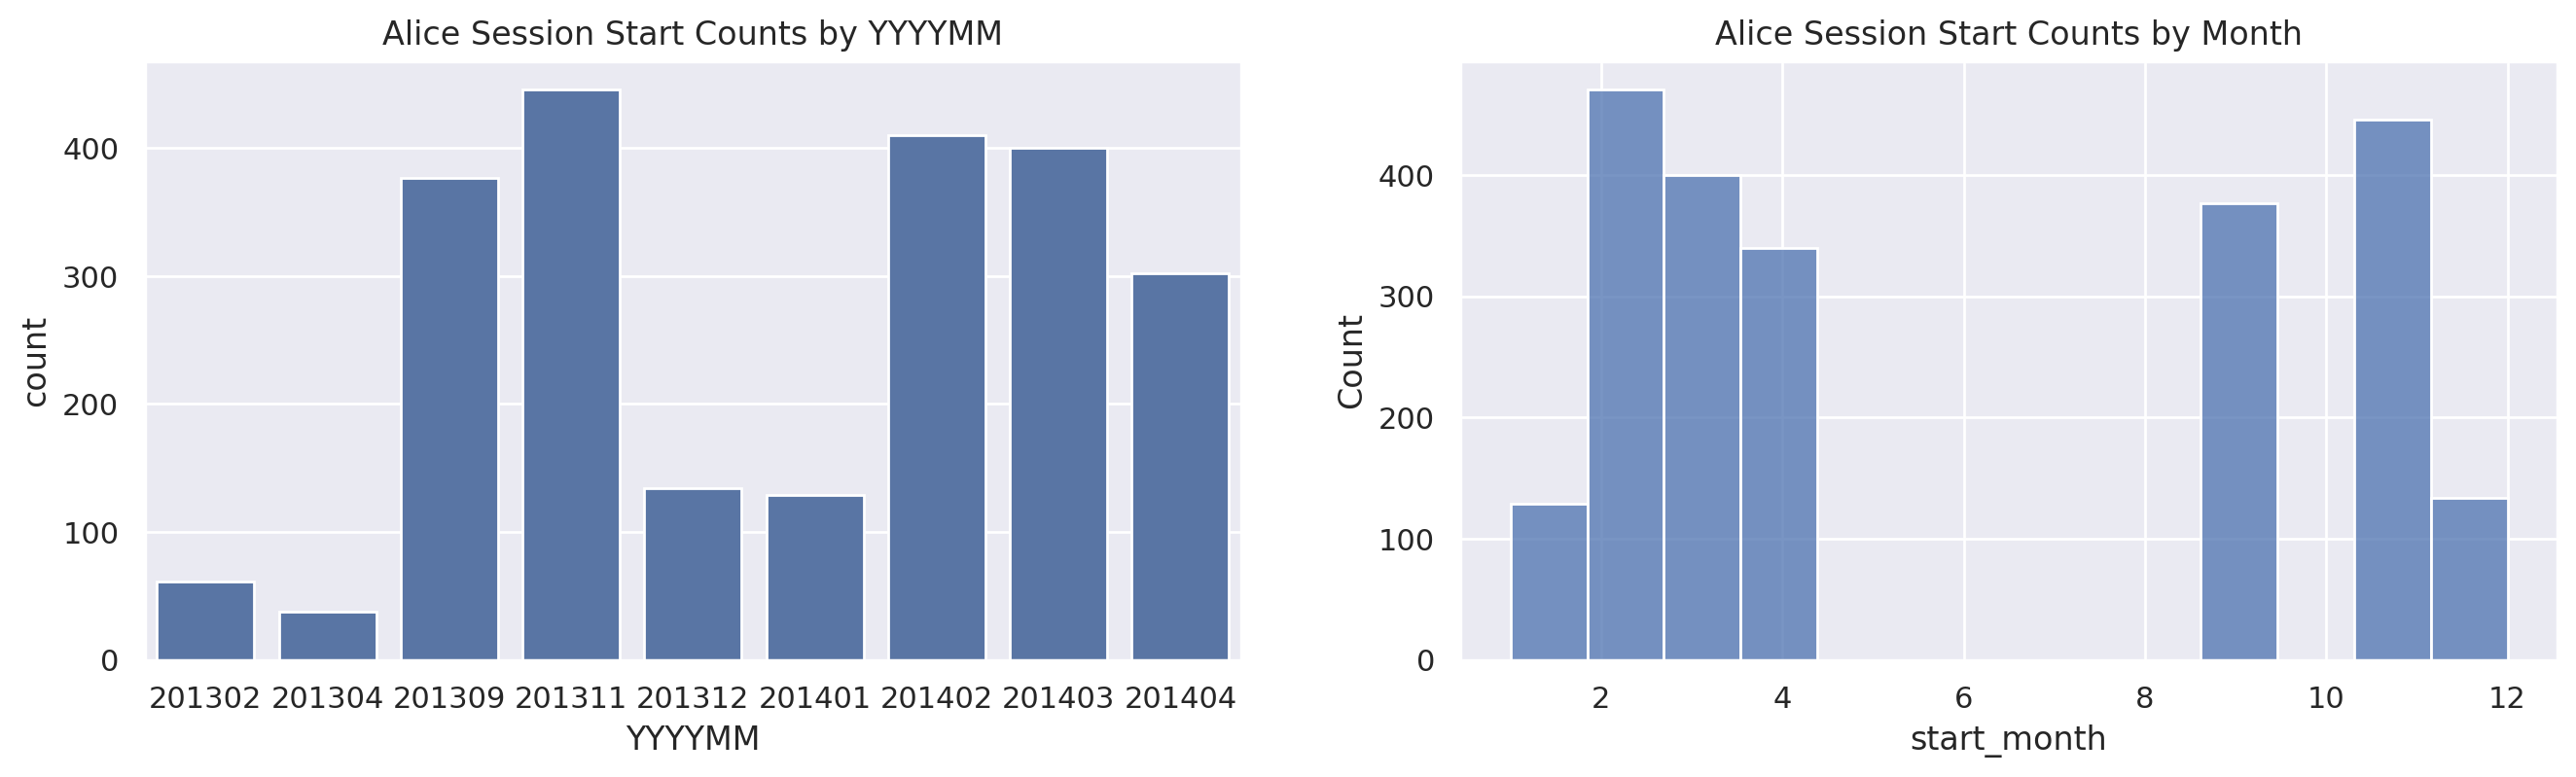

In [26]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
sns.countplot(x='YYYYMM', data=alice_time_df, ax=axes[0])
sns.histplot(x='start_month', data=alice_time_df, ax=axes[1])
axes[0].set_title('Alice Session Start Counts by YYYYMM')
axes[1].set_title('Alice Session Start Counts by Month')

plt.subplots_adjust(wspace=.2)

plt.show()


In [27]:
def to_hstack(X_sparce, new_features):
    # adds new features to a sparce matrix
    new_features_csr = csr_matrix(new_features)
    X = hstack([X_sparce, new_features_csr])
    return X


def train_with_new_features(X_train, y_train, X_test, new_features, new_features_test, feature_list=[], C=1):

    print("Adding features:")
    if len(feature_list) == 0:
        feature_list = new_features.columns
    for feature in feature_list:
        print(feature)

    adding = new_features[feature_list]
    adding_test = new_features_test[feature_list]

    X_train_new = to_hstack(X_train, adding.iloc[:idx_split])
    X_test_new = to_hstack(X_test, adding_test.iloc[:idx_split])

    logit, scores = train_and_predict(X_train_new, y_train, X_test_new, C=C)
    return logit, scores


new_features = pd.DataFrame(index=train_df.index)
new_features["YYYYMM"] = time_df['min'].map(YYYYMM)
new_features["start_month"] = time_df['min'].map(start_month)

new_features_test = pd.DataFrame(index=test_df.index)
new_features_test["YYYYMM"] = time_test['min'].map(YYYYMM)
new_features_test["start_month"] = time_test['min'].map(start_month)

print(new_features.head())
print()
print(new_features_test.head())

            YYYYMM  start_month
session_id                     
21669       201301            1
54843       201301            1
77292       201301            1
114021      201301            1
146670      201301            1

            YYYYMM  start_month
session_id                     
1           201410           10
2           201407            7
3           201412           12
4           201411           11
5           201405            5


In [28]:

'''
X_train_times = to_hstack(X_train, new_features.iloc[:idx_split])
X_test_times = to_hstack(X_test, new_features_test.iloc[:idx_split])

logit, scores2 = train_and_predict(X_train_times, y_train, X_test_times)

print(scores2.mean())
'''

# Score w/ Unstandardized YYYYMM and start month features
feature_list = ['YYYYMM']
logit, scores2 = train_with_new_features(X_train, y_train, X_test, new_features,
                                         new_features_test, feature_list)
print(scores2.mean())

Adding features:
YYYYMM
CV scores [0.63535981 0.53959722 0.55850493 0.74429573 0.74146433 0.81767149
 0.7987768  0.82962826 0.46788816 0.80814004]
CV mean: 0.6941326777251964, CV std: 0.12619132540807543
0.6941326777251964


In [29]:
def std_features(X, features_to_standardize=[]):
    if len(features_to_standardize) == 0:
        features_to_standardize = X.columns
    for feature in features_to_standardize:
        X[feature] = (X[feature] - X[feature].mean())/X[feature].std()
    return X

new_features = std_features(new_features)
new_features_test = std_features(new_features_test)


print(new_features.head())
print()
print(new_features_test.head())

              YYYYMM  start_month
session_id                       
21669      -1.744402    -0.943565
54843      -1.744402    -0.943565
77292      -1.744402    -0.943565
114021     -1.744402    -0.943565
146670     -1.744402    -0.943565

              YYYYMM  start_month
session_id                       
1           0.742055     0.742055
2          -0.388623    -0.388623
3           1.495840     1.495840
4           1.118948     1.118948
5          -1.142409    -1.142409


In [30]:
# Score w/ Standardized YYYYMM features
feature_list = ['YYYYMM']
logit, scores3 = train_with_new_features(X_train, y_train, X_test, new_features,
                                         new_features_test, feature_list)

print(scores3.mean())

Adding features:
YYYYMM
CV scores [0.8119353  0.6702739  0.89111793 0.93141418 0.8420019  0.88529349
 0.88997954 0.8696838  0.91698926 0.92287884]
CV mean: 0.8631568136945272, CV std: 0.07309762705306148
0.8631568136945272


In [31]:
scores3.mean()-scores1.mean()

0.003789221537476628

### **Discuss your findings:**
Looking at the plots for Alice's month-to-month sessions, we can see that she didn't start having a large number of sessions until the back half of 2013, where her usage started to influx considerably. It would be good to consider times where the start dates of the sessions are in this influx (i.e. 2013-09 and beyond).

After standardizing, adding the new year:month feature, our score increases by a marginal amount (in the ball park of $.0037$). If we also add the start_month feature, our score lowers this improvement by about $.0012$, and running the model with only start_month decreases the base model by $.0021$.

We still see large variations in the split, but with our minimum score increasing slightly (maximum score staying the same).




---



---


## Q1.5: Third Try: Add more features? (10pt)
- Add to the training set a new feature "n_unique_sites" – the number of the unique web-sites in a session. Calculate how the quality on the validation set has changed. Shall we add this feature?

- Add two new features: start_hour and morning. Calculate the metric. Which of these features gives an improvement.

The `start_hour` feature is the hour at which the session started (from 0 to 23), and the binary feature `morning` is equal to 1 if the session started in the morning and 0 if the session started later (we assume that morning means `start_hour` is equal to 11 or less).

Will you scale the new features? Make your assumptions and test them in practice.

In [32]:
def n_unique_sites(row):
    check = np.unique(row)
    if check[0] == 0:
        return len(check) - 1
    else:
        return len(check)

def start_hour(ts):
    return ts.hour

def morning(ts):
    if ts.hour <= 11:
        return 1
    else:
        return 0

train_sites = train_df[sites]
test_sites = test_df[sites]

new_features["n_unique_sites"] = train_sites.apply(lambda row: n_unique_sites(row), axis=1)
new_features["start_hour"] = time_df['min'].map(start_hour)
new_features["morning"] = time_df['min'].map(morning)

new_features_test['n_unique_sites'] = test_sites.apply(lambda row: n_unique_sites(row), axis=1)
new_features_test["start_hour"] = time_test['min'].map(start_hour)
new_features_test["morning"] = time_test['min'].map(morning)

# features probably don't need to be standardized

new_features = std_features(new_features, ['n_unique_sites', 'start_hour'])
new_features_test = std_features(new_features_test, ['n_unique_sites', 'start_hour'])

print(new_features.head())
print()
print(new_features_test.head())

              YYYYMM  start_month  n_unique_sites  start_hour  morning
session_id                                                            
21669      -1.744402    -0.943565       -1.457579   -1.357364        1
54843      -1.744402    -0.943565       -1.457579   -1.357364        1
77292      -1.744402    -0.943565        0.144865   -1.357364        1
114021     -1.744402    -0.943565       -0.255746   -1.357364        1
146670     -1.744402    -0.943565        0.144865   -1.357364        1

              YYYYMM  start_month  n_unique_sites  start_hour  morning
session_id                                                            
1           0.742055     0.742055        1.796753   -0.487961        1
2          -0.388623    -0.388623       -1.629731   -0.487961        1
3           1.495840     1.495840       -1.249011    0.809753        0
4           1.118948     1.118948        0.654592   -0.812390        1
5          -1.142409    -1.142409        1.035312    0.809753        0


In [33]:
feature_list = ['YYYYMM', 'n_unique_sites', 'start_hour', 'morning']

logit, scores4 = train_with_new_features(X_train, y_train, X_test, new_features,
                                         new_features_test, feature_list)

Adding features:
YYYYMM
n_unique_sites
start_hour
morning
CV scores [0.76189449 0.77613056 0.94844238 0.96492988 0.89987126 0.95946338
 0.92246496 0.93112732 0.95466052 0.95937825]
CV mean: 0.9078363010593729, CV std: 0.07203352661638876


In [34]:
scores4.mean()-scores3.mean()

0.044679487364845616

### **Discuss your findings:**

Running with just YYYYMM and n_unique_sites, we get a slight increase in score of around $.0033$, so adding this feature seems good. The other features increase the score significantly by about $.045$, a whole magnitude over the other feature additions, bringing our current score to just over $.9$.

While our standard deviation is still roughly the same as before, our min, max spread has improved to $\{.76, .96\}$, with our first split having the lowest score, which wasn't the case in the previous models.



---



---



## Q1.6 Last Try: Regularization and Parameter Tuning (10pt)
We have introduced features that improve the quality of our model in comparison with the first baseline. Can we do even better? After we have changed the training and test sets, it almost always makes sense to search for the optimal hyperparameters - the parameters of the model that do not change during training.

In the logistic regression that we use, the weights of each feature are changing, and we find their optimal values during training; meanwhile, the regularization parameter remains constant. This is the hyperparameter that we are going to optimize now.

We will try to beat the default parameter value $C=1$ by optimizing the regularization parameter. We will take a list of possible values of $C$ and calculate the quality metric on the validation set for each of $C$-values.

What is the value of parameter $C$ that corresponds to the highest model.


In [35]:
# your code

feature_list = ['YYYYMM', 'n_unique_sites', 'start_hour', 'morning']

X_train_tune = to_hstack(X_train, new_features[feature_list].iloc[:idx_split])
X_test_tune = to_hstack(X_test, new_features_test[feature_list].iloc[:idx_split])

time_split = TimeSeriesSplit(n_splits=10)
[(el[0].shape, el[1].shape) for el in time_split.split(X_train_tune)]

c_values = np.logspace(-2, 2, 10)

logit = LogisticRegression(random_state=17, solver='liblinear')

logit_grid_searcher = GridSearchCV(estimator=logit, param_grid={'C': c_values},
                                  scoring='roc_auc', n_jobs=1, cv=time_split, verbose=1)

In [36]:
# logit_grid_searcher.fit(X_train_tune, y_train)

In [37]:
# logit_grid_searcher.best_score_, logit_grid_searcher.best_params_

In [38]:
logit, scores5 = train_and_predict(X_train_tune, y_train, X_test_tune, C=12.92)

CV scores [0.782364   0.76351262 0.95175148 0.9722613  0.90536559 0.95728029
 0.94450155 0.93009467 0.96253317 0.9601587 ]
CV mean: 0.9129823367818993, CV std: 0.07239260962765523


### **Discuss your findings:**

Doing a tuning on the most avdanced model, we find our optimal parameter $C^* \approx 12.92 (=12.915496650148826)$ with a score of $.913$. Still the standard deviation is about the same (in fact, slightly larger), and the improvements are stagnating, but we can see that we are finishing the time series at a higher point than before, which is ideal.

# Q2: Freeride (40pt)

In this part, you'll need to beat the 2 baselines mentioned in the class. No more step-by-step instructions.

Here are a few tips for finding new features: think about what you can come up with using existing features, try multiplying or dividing two of them, justify or decline your hypotheses with plots, extract useful information from time series data (time1 ... time10), do not hesitate to convert an existing feature (for example, take a logarithm), etc. We encourage you to try new ideas and models - it's fun!

In [77]:
# to ensure baselines, num X site features (shape[1] = 41602)
print(X_train.shape[1], X_test.shape[1])
print(new_features.columns)

a = 41602

41602 41602
Index(['YYYYMM', 'start_month', 'n_unique_sites', 'start_hour', 'morning',
       'time_of_day', 'afternoon', 'early_afternoon', 'late_afternoon',
       'evening', 'session_time', 'log_session_time'],
      dtype='object')


We would like to test a feature for session time. This stems from our initial EDA where we showed that Alice's average session was half that of the average session time from the entire dataset. We want decrease its values, since the values can grow to $1800$. To do this, we do two methods, one being the usual standardization, the other by taking the logarithm (adding 1 to the value to not deal with 0's).

In [50]:
new_features["session_time"] = time_df["seconds"]
new_features["log_session_time"] = np.log(time_df["seconds"] + 1)
new_features_test["session_time"] = time_test["seconds"]
new_features_test["log_session_time"] = np.log(time_test["seconds"] + 1)

new_features = std_features(new_features, ['session_time'])
new_features_test = std_features(new_features_test, ['session_time'])

In [53]:
feature_list = ['YYYYMM', 'n_unique_sites', 'start_hour', 'morning', 'session_time']

logit, scores6 = train_with_new_features(X_train, y_train, X_test, new_features,
                                         new_features_test, feature_list, C=12.92)

print(scores6 > scores5)
print(scores6.mean() - scores5.mean())
print(scores6.std() - scores5.std())

Adding features:
YYYYMM
n_unique_sites
start_hour
morning
session_time
CV scores [0.78213513 0.7669658  0.95177508 0.97266076 0.90595982 0.9579626
 0.94615361 0.93035934 0.96297537 0.96027589]
CV mean: 0.9137223402362423, CV std: 0.07191213665125104
[False  True  True  True  True  True  True  True  True  True]
0.0007400034543429967
-0.0004804729764041893


In [54]:
feature_list = ['YYYYMM', 'n_unique_sites', 'start_hour', 'morning', 'log_session_time']

logit, scores7 = train_with_new_features(X_train, y_train, X_test, new_features,
                                         new_features_test, feature_list, C=12.92)

print(scores7 > scores5)
print(scores7.mean() - scores5.mean())
print(scores7.std() - scores5.std())

Adding features:
YYYYMM
n_unique_sites
start_hour
morning
log_session_time
CV scores [0.78414597 0.76541025 0.95197542 0.97178151 0.90558536 0.95828391
 0.94629517 0.93012438 0.96283038 0.9602724 ]
CV mean: 0.9136704761357006, CV std: 0.07181999659549743
[ True  True  True False  True  True  True  True  True  True]
0.0006881393538012981
-0.0005726130321578038


Just adding session time didn't improve the model that much for either scaling options, but it did improve (pretty much) across the board. We consider the model as a whole, and determine that start_hour is redundant (something we will show later), so we remove it from our feature list. Since normal standardization outperformed log scaling, we progress with the standardized sesion time.

In [55]:
feature_list = ['YYYYMM', 'n_unique_sites', 'morning', 'session_time']

logit, scores8 = train_with_new_features(X_train, y_train, X_test, new_features,
                                         new_features_test, feature_list, C=12.92)

print(scores8 > scores5)
print(scores8.mean() - scores5.mean())
print(scores8.std() - scores5.std())

Adding features:
YYYYMM
n_unique_sites
morning
session_time
CV scores [0.8788314  0.79725273 0.94293708 0.96978855 0.91122161 0.94637791
 0.95184252 0.92811661 0.95251185 0.94810056]
CV mean: 0.9226980801564897, CV std: 0.048366621369835446
[ True  True False False  True False  True False False False]
0.009715743374590358
-0.024025988257819784


We can see that this model is much improved over the previous ones, further increasing our score and decreasing our standard deviation. Both standardized and log are better, but the log scaled version is slightly worse.

Since we improved the model quite a bit, we will update our $C$ parameter:

In [57]:
feature_list = ['YYYYMM', 'n_unique_sites', 'morning', 'session_time']

X_train_tune = to_hstack(X_train, new_features[feature_list].iloc[:idx_split])
X_test_tune = to_hstack(X_test, new_features_test[feature_list].iloc[:idx_split])

time_split = TimeSeriesSplit(n_splits=10)
[(el[0].shape, el[1].shape) for el in time_split.split(X_train_tune)]

c_values = np.logspace(-2, 2, 10)

logit = LogisticRegression(random_state=17, solver='liblinear')

logit_grid_searcher = GridSearchCV(estimator=logit, param_grid={'C': c_values},
                                  scoring='roc_auc', n_jobs=1, cv=time_split, verbose=1)

logit_grid_searcher.fit(X_train_tune, y_train)

logit_grid_searcher.best_score_, logit_grid_searcher.best_params_

Fitting 10 folds for each of 10 candidates, totalling 100 fits


(0.9233166778392313, {'C': 4.6415888336127775})

Our updated parameter $C \approx 4.64 (= 4.6415888336127775)$ with a score of $.92332$, which beats the required score, but there are more features I can think to try.

In [156]:
feature_list = ['YYYYMM', 'n_unique_sites', 'morning', 'session_time']

logit, scores7 = train_with_new_features(X_train, y_train, X_test, new_features,
                                         new_features_test, feature_list, C=4.64)

print(scores7 > scores5)
print(scores7.mean() - scores5.mean())
print(scores7.std() - scores5.std())

model_coef = logit.coef_
model_coef = model_coef.flatten()
print(model_coef[a:])

Adding features:
YYYYMM
n_unique_sites
morning
session_time
CV scores [0.87963298 0.79883522 0.94513768 0.96797577 0.91544068 0.94932596
 0.94639732 0.92865652 0.95209647 0.94965979]
CV mean: 0.9233158396211232, CV std: 0.0476408118830553
[ True  True False False  True False  True False False False]
0.010333502839223851
-0.02475179774459993
[-4.43613550e-01 -2.04278441e-03 -4.01569452e+00 -1.50241909e-01]


---

Here, we move to add the remaining timeslots of a given day as a categorical variable with splits (based on session start hour) given as:

0 <= night <= 5

6 <= morning <= 11

12 <= afternoon <= 17

18 <= evening <= 23



<ipython-input-58-8d35b3d12780>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alice_time_df['time_of_day'] = alice_time_df['min'].map(time_of_day)


Empty DataFrame
Columns: [target, min, max, seconds, YYYYMM, time_of_day]
Index: []


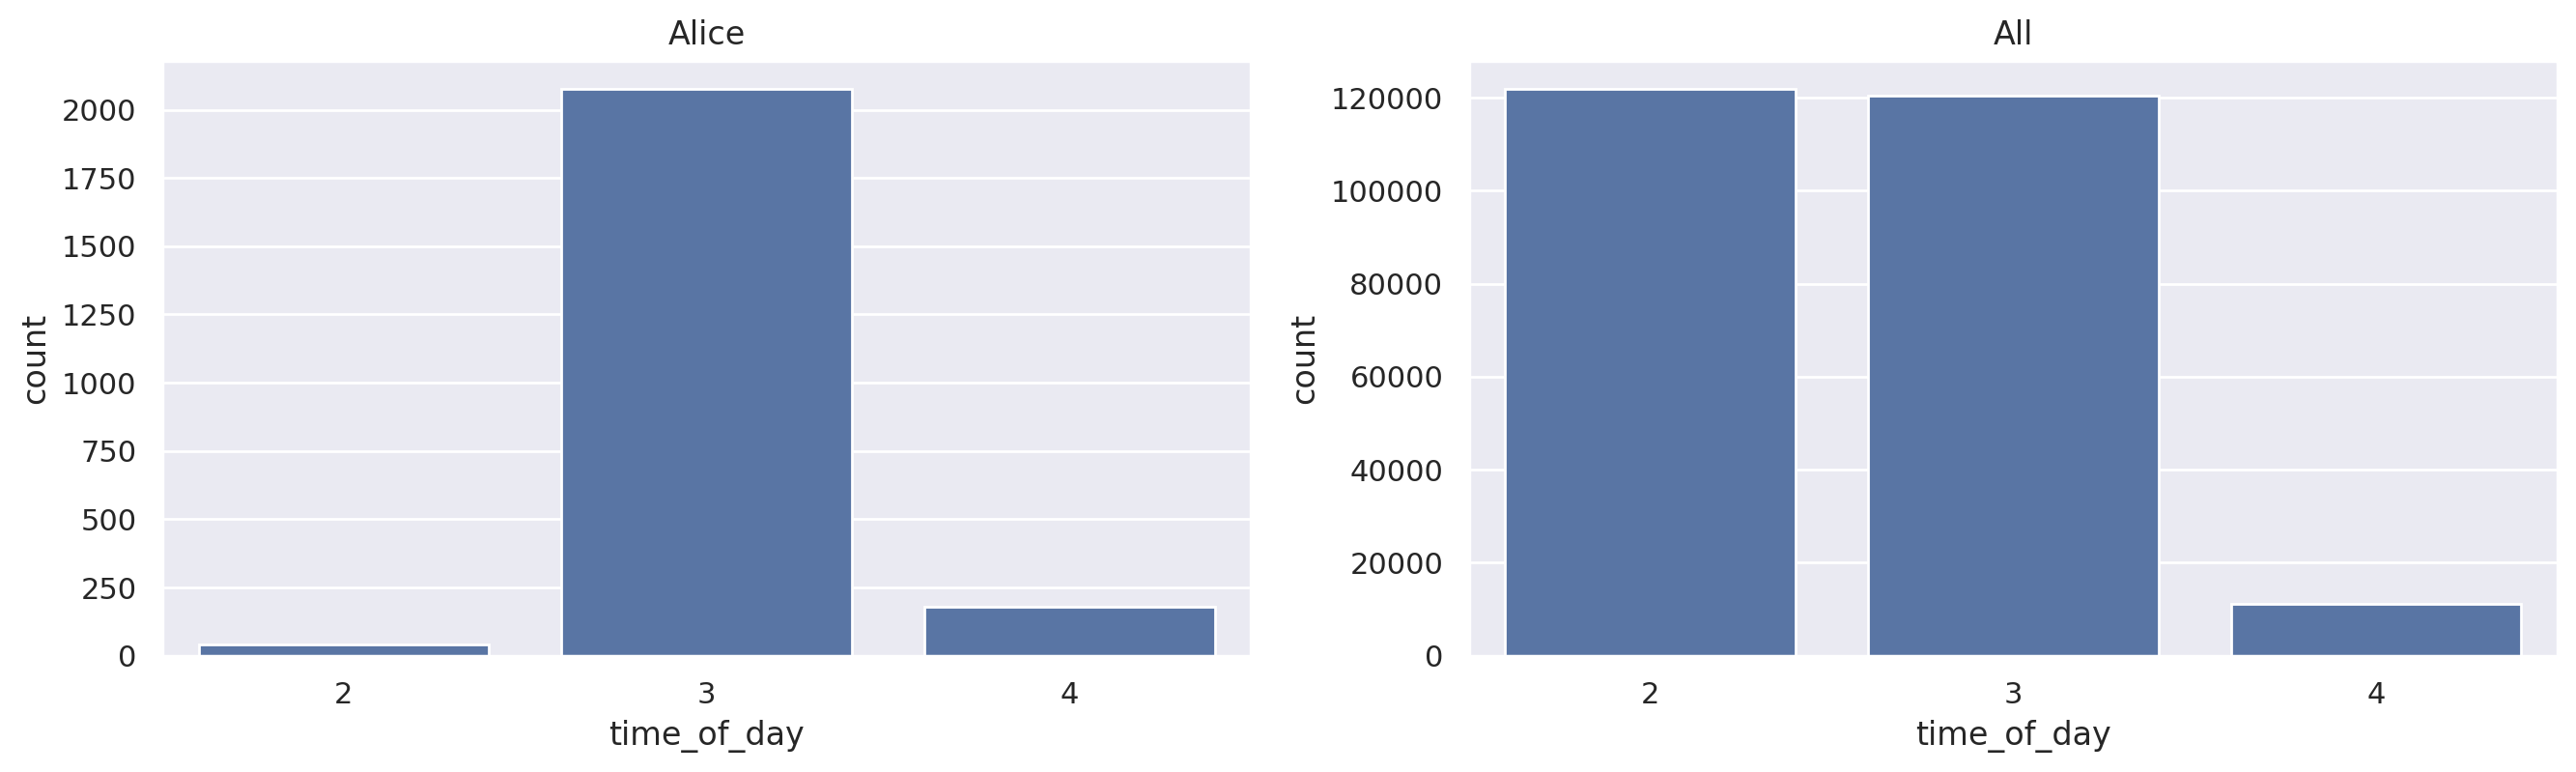

In [58]:
def time_of_day(ts):
    if ts.hour < 6:
        return 1
    elif ts.hour < 12:
        return 2
    elif ts.hour < 18:
        return 3
    else:
        return 4

time_df['time_of_day'] = time_df['min'].map(time_of_day)
alice_time_df['time_of_day'] = alice_time_df['min'].map(time_of_day)
print(time_df[time_df['time_of_day'] == 0])

_, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
sns.countplot(x='time_of_day', data=alice_time_df, ax=axes[0])
sns.countplot(x='time_of_day', data=time_df, ax=axes[1])
axes[0].set_title('Alice')
axes[1].set_title('All')

plt.subplots_adjust(wspace=.2)

plt.show()

Remark: while there are 4 charted times of day, we note that a $1$ never appears in either graph, which makes a night time boolean useless.
Morning still appears to be an extremely useful feature, given that a large number of sessions in the dataset display morning session start, but Alice has very few morning sessions.

Keeping note of this information, we add a few boolean features, effectively a onehot of times of day with the morning feature:

early_afternoon (12<=hour<=14)

late_afternoon (15<=hour<=17)

afternon (early_afternoon+late_afternoon)

evening (18<=hour<=23)

We won't be using early and late afternoon features when we use afternoon, just venturing to see if there's a major difference.

In [59]:
def afternoon(ts):
    if ts.hour <= 14 and ts.hour >= 12:
        return 1
    else:
        return 0

def early_afternoon(ts):
    if ts.hour <= 14 and ts.hour >= 12:
        return 1
    else:
        return 0

def late_afternoon(ts):
    if ts.hour <= 17 and ts.hour >= 15:
        return 1
    else:
        return 0

def evening(ts):
    if ts.hour <= 23 and ts.hour >= 18:
        return 1
    else:
        return 0

new_features['time_of_day'] = time_df['min'].map(time_of_day)
new_features['afternoon'] = time_df['min'].map(afternoon)
new_features['early_afternoon'] = time_df['min'].map(early_afternoon)
new_features['late_afternoon'] = time_df['min'].map(late_afternoon)
new_features['evening'] = time_df['min'].map(evening)
new_features_test['time_of_day'] = time_test['min'].map(time_of_day)
new_features_test['afternoon'] = time_test['min'].map(afternoon)
new_features_test['early_afternoon'] = time_test['min'].map(early_afternoon)
new_features_test['late_afternoon'] = time_test['min'].map(late_afternoon)
new_features_test['evening'] = time_test['min'].map(evening)

print(new_features.columns)
print(new_features_test.columns)

Index(['YYYYMM', 'start_month', 'n_unique_sites', 'start_hour', 'morning',
       'time_of_day', 'afternoon', 'early_afternoon', 'late_afternoon',
       'evening', 'session_time', 'log_session_time'],
      dtype='object')
Index(['YYYYMM', 'start_month', 'n_unique_sites', 'start_hour', 'morning',
       'time_of_day', 'afternoon', 'early_afternoon', 'late_afternoon',
       'evening', 'session_time', 'log_session_time'],
      dtype='object')


In [60]:
feature_list = ['YYYYMM', 'n_unique_sites', 'morning', 'afternoon', 'evening', 'session_time']

logit, scores8 = train_with_new_features(X_train, y_train, X_test, new_features,
                                         new_features_test, feature_list, C=4.64)

print(scores8 > scores7)
print(scores8.mean() - scores7.mean())
print(scores8.std() - scores7.std())

Adding features:
YYYYMM
n_unique_sites
morning
afternoon
evening
session_time
CV scores [0.59106955 0.76478569 0.96342152 0.96098954 0.88501711 0.96750061
 0.93943518 0.93414457 0.96824192 0.96872103]
CV mean: 0.8943326725457185, CV std: 0.11748323451595834
[False False  True False False  True False  True  True  True]
-0.01938966769052386
0.0455710978647073


In [61]:
feature_list = ['YYYYMM', 'n_unique_sites', 'morning', 'early_afternoon', 'late_afternoon', 'evening']

logit, scores8 = train_with_new_features(X_train, y_train, X_test, new_features,
                                         new_features_test, feature_list, C=12.92)

print(scores8 > scores7)
print(scores8.mean() - scores7.mean())
print(scores8.std() - scores7.std())

Adding features:
YYYYMM
n_unique_sites
morning
early_afternoon
late_afternoon
evening
CV scores [0.58064438 0.76118921 0.96230542 0.96509487 0.88493186 0.96508942
 0.94624128 0.93447407 0.96839923 0.96689907]
CV mean: 0.8935268815736668, CV std: 0.12078952016602151
[False False  True False False  True  True  True  True  True]
-0.02019545866257555
0.04887738351477047


We can see that our initial assumptions with the start_hour feature hold true for these break downs of times of day, where the added information only hinders the performance of the model. The morning feature gives the model all the important information it needs about when Alice's sessions tend to occur with respect to the rest of the data: NOT in the morning.


We wish to observe Alice's top sites once again and create a feature for the number of Alice's favorite sites are visited. We begin by doing this for her top 10 favorite sites, then increase or decrease the threshold depending on the model's performance.

In [130]:
# rehashing this down here for ease of use
alice_train_df = train_df[train_df['target'] == 1]
alice_top_sites = (
    pd.Series(alice_train_df[sites].values.flatten())
    .value_counts()
    .sort_values(ascending=False)
    .head(30)
)

favorite_index = alice_top_sites.index
print(favorite_index)

Index([  77,   80,   76,   29,   21,   81,   22,  879,   75,   82,   23,   35,
        881,   37,   33, 3000,  733,   30,   78,  941, 7832,   52,  704,    0,
       2078,  617, 1057,  942,  270,  335],
      dtype='uint16')


In [97]:
A = np.asarray([1,2,3,3])

print(np.intersect1d(A, A, assume_unique=False))
print(np.intersect1d(A, A, assume_unique=True))

[1 2 3]
[1 2 3 3 3]


In [145]:
def favorite(row, favorites, unique=False):
    return  len(np.intersect1d(np.unique(row), favorites, assume_unique=unique))

favorites = favorite_index[:10]

new_features['favorite_10'] = train_df[sites].apply(lambda row: favorite(row, favorites, unique=True), axis=1)
new_features_test['favorite_10'] = test_df[sites].apply(lambda row: favorite(row, favorites, unique=True), axis=1)
new_features['unique_favorite_10'] = train_df[sites].apply(lambda row: favorite(row, favorites), axis=1)
new_features_test['unique_favorite_10'] = test_df[sites].apply(lambda row: favorite(row, favorites), axis=1)

In [161]:
feature_list = ['YYYYMM', 'n_unique_sites', 'morning', 'session_time', 'favorite_10']

logit, scores8 = train_with_new_features(X_train, y_train, X_test, new_features,
                                         new_features_test, feature_list, C=4.64)

print(scores8 > scores7)
print(scores8.mean() - scores7.mean())
print(scores8.std() - scores7.std())

model_coef = logit.coef_
model_coef = model_coef.flatten()
print(model_coef[a:])

Adding features:
YYYYMM
n_unique_sites
morning
session_time
favorite_10
CV scores [0.87853935 0.79651815 0.94456983 0.96806912 0.91467289 0.94891923
 0.94692656 0.92962131 0.95274383 0.95058436]
CV mean: 0.923116464534527, CV std: 0.048449785623052244
[False False False  True False False  True  True  True  True]
-0.0001993750865961763
0.0008089737399969432
[-0.44203501 -0.10465883 -4.0180591  -0.15222783  0.18808385]


In [98]:
feature_list = ['YYYYMM', 'n_unique_sites', 'morning', 'session_time', 'unique_favorite_10']

logit, scores8 = train_with_new_features(X_train, y_train, X_test, new_features,
                                         new_features_test, feature_list, C=4.64)

print(scores8 > scores7)
print(scores8.mean() - scores7.mean())
print(scores8.std() - scores7.std())

model_coef = logit.coef_
model_coef = model_coef.flatten()
print(model_coef[a:])

Adding features:
YYYYMM
n_unique_sites
morning
session_time
unique_favorite
CV scores [0.87853935 0.79651815 0.94456983 0.96806912 0.91467289 0.94891923
 0.94692656 0.92962131 0.95274383 0.95058436]
CV mean: 0.923116464534527, CV std: 0.048449785623052244
[False False False  True False False  True  True  True  True]
-0.0001993750865961763
0.0008089737399969432
[-0.44203501 -0.10465883 -4.0180591  -0.15222783  0.18808385]


From the addition of counts on visited sites favored by Alice, we see the model hasn't improved or depreciated, which is a good sign given the previous model is tuned, where this isn't. The difference between unique and non-unique visits is, according to the model outputs, nonexistent. We choose the non-unique favorites feature to ensure no data is lost.

We progress from here by checking (independently) for counts in the top 8 and top 12 to see in which direction improvement sways (if at all). Either direction will be interesting to see, because while decreasing the threshold gives us more specific data for Alice, we increase the number of nonzero entries, while increasing the threshold gives us more nonzeros, but allows more variance into the feature.

**Remark from the future**

While doing the testing for this feature, I've found a lot of interesting nuance to how it affects the model with respect to increasing the model's threshold. From 10-18, we only saw worsening performance, but not so much to stop. At 20, we began to see improvement once more, and continued to see improvement until we reached a relative "cap" at around the top 30.

For the sake of your own runtime, since each of these blocks take 40-60 seconds to run, I've commented a lot of the code out in case you hit run all. If you wish to inspect the improvement yourself, feel free to remove them.

The results seemed really promising for this feature, but in the end, there wasn't any major break throughs, even after tuning. You can observe my process below, but I'll continue with feature engineering here.

---

Here I would like to add the boolean of weekday as a feature, considering the start of the session for the day. Without engineering some crazy feature like "consecutive days" or something intricate, this is the last thing I can think of that could help improve the model above.

In [154]:
def day_of_week(ts):
    return ts.weekday()

new_features['day_of_week'] = time_df['min'].map(day_of_week)
new_features_test['day_of_week'] = time_test['min'].map(day_of_week)

In [155]:
feature_list = ['YYYYMM', 'n_unique_sites', 'morning', 'session_time', 'day_of_week']

logit, scores8 = train_with_new_features(X_train, y_train, X_test, new_features,
                                         new_features_test, feature_list, C=4.64)

print(scores8 > scores7)
print(scores8.mean() - scores7.mean())
print(scores8.std() - scores7.std())

model_coef = logit.coef_
model_coef = model_coef.flatten()
print(model_coef[a:])

Adding features:
YYYYMM
n_unique_sites
morning
session_time
day_of_week
CV scores [0.84932429 0.78762175 0.94408596 0.9690135  0.91606391 0.95508363
 0.94277308 0.94089215 0.9608702  0.96634993]
CV mean: 0.9232078420254384, CV std: 0.05605242933876029
[False False False  True  True  True False  True  True  True]
-0.0001079975956848056
0.00841161745570499
[-0.56861451 -0.01630317 -4.05445402 -0.18214929 -0.39487868]


Another very close, but not better, model to the one above. This also beats the target score, but isn't better than what we had. We combine this with favorite_10 to see if there's any improvement that way.

In [157]:
feature_list = ['YYYYMM', 'n_unique_sites', 'morning', 'session_time', 'day_of_week', 'favorite_10']

logit, scores8 = train_with_new_features(X_train, y_train, X_test, new_features,
                                         new_features_test, feature_list, C=4.64)

print(scores8 > scores7)
print(scores8.mean() - scores7.mean())
print(scores8.std() - scores7.std())

model_coef = logit.coef_
model_coef = model_coef.flatten()
print(model_coef[a:])

Adding features:
YYYYMM
n_unique_sites
morning
session_time
day_of_week
favorite_10
CV scores [0.84969774 0.78529137 0.94369807 0.96893318 0.91532816 0.95459903
 0.9431318  0.94178623 0.96140954 0.96680058]
CV mean: 0.9230675690814069, CV std: 0.05664314743433764
[False False False  True False  True False  True  True  True]
-0.00024827053971632207
0.00900233555128234
[-0.56786503 -0.12447615 -4.05718235 -0.18442352 -0.39596181  0.20139731]


Not any better. We try tuning as a last resort (without favorite_10).

In [158]:
feature_list = ['YYYYMM', 'n_unique_sites', 'morning', 'session_time', 'day_of_week']

X_train_tune = to_hstack(X_train, new_features[feature_list].iloc[:idx_split])
X_test_tune = to_hstack(X_test, new_features_test[feature_list].iloc[:idx_split])

time_split = TimeSeriesSplit(n_splits=10)
[(el[0].shape, el[1].shape) for el in time_split.split(X_train_tune)]

c_values = np.logspace(-2, 2, 10)

logit = LogisticRegression(random_state=17, solver='liblinear')

logit_grid_searcher = GridSearchCV(estimator=logit, param_grid={'C': c_values},
                                  scoring='roc_auc', n_jobs=1, cv=time_split, verbose=1)

logit_grid_searcher.fit(X_train_tune, y_train)

logit_grid_searcher.best_score_, logit_grid_searcher.best_params_

Fitting 10 folds for each of 10 candidates, totalling 100 fits


(0.9232084559038434, {'C': 4.6415888336127775})

We find that this model, when tuned, is not better than the one above (doesn't beat .9233).

## Best Model

The best model from the experimentation I've done in this document is the following, very simple model.

In [162]:
feature_list = ['YYYYMM', 'n_unique_sites', 'morning', 'session_time']

final_model, best_score = train_with_new_features(X_train, y_train, X_test, new_features,
                                         new_features_test, feature_list, C=4.6415888)

final_model_coef = final_model.coef_
final_model_coef = final_model_coef.flatten()
print("non-site feature coefficients:",final_model_coef[a:])

Adding features:
YYYYMM
n_unique_sites
morning
session_time
CV scores [0.87963632 0.79882745 0.94514608 0.96797577 0.91543663 0.94932395
 0.94640536 0.92865201 0.95209937 0.9496593 ]
CV mean: 0.9233162226799285, CV std: 0.047643364278202545
non-site feature coefficients: [-4.43659147e-01 -2.07645960e-03 -4.01589460e+00 -1.50226268e-01]


---

Below is my process for testing the "favorites" threshold.

In [139]:
favorites = favorite_index[:8]

new_features['favorite_8'] = train_df[sites].apply(lambda row: favorite(row, favorites, unique=True), axis=1)
new_features_test['favorite_8'] = test_df[sites].apply(lambda row: favorite(row, favorites, unique=True), axis=1)


favorites = favorite_index[:12]

new_features['favorite_12'] = train_df[sites].apply(lambda row: favorite(row, favorites, unique=True), axis=1)
new_features_test['favorite_12'] = test_df[sites].apply(lambda row: favorite(row, favorites, unique=True), axis=1)

In [140]:
'''
feature_list = ['YYYYMM', 'n_unique_sites', 'morning', 'session_time', 'favorite_8']

logit, scores8 = train_with_new_features(X_train, y_train, X_test, new_features,
                                         new_features_test, feature_list, C=4.64)

print(scores8 > scores7)
print(scores8.mean() - scores7.mean())
print(scores8.std() - scores7.std())

model_coef = logit.coef_
model_coef = model_coef.flatten()
print(model_coef[a:])
'''

Adding features:
YYYYMM
n_unique_sites
morning
session_time
favorite_8
CV scores [0.87838687 0.79656238 0.94436949 0.96786288 0.91455713 0.94884738
 0.9469539  0.92953978 0.95266554 0.95049161]
CV mean: 0.9230236957550876, CV std: 0.04841269614758058
[False False False False False False  True  True  True  True]
-0.00029214386603559905
0.0007718842645252771
[-0.44152554 -0.08308563 -4.01693885 -0.15064424  0.16817675]


In [141]:
'''
feature_list = ['YYYYMM', 'n_unique_sites', 'morning', 'session_time', 'favorite_12']

logit, scores8 = train_with_new_features(X_train, y_train, X_test, new_features,
                                         new_features_test, feature_list, C=4.64)

print(scores8 > scores7)
print(scores8.mean() - scores7.mean())
print(scores8.std() - scores7.std())

model_coef = logit.coef_
model_coef = model_coef.flatten()
print(model_coef[a:])
'''

Adding features:
YYYYMM
n_unique_sites
morning
session_time
favorite_12
CV scores [0.87761126 0.79425133 0.9443163  0.96790413 0.91429437 0.94882754
 0.94721772 0.92980505 0.95240746 0.95069175]
CV mean: 0.9227326911047978, CV std: 0.04910569889294832
[False False False False False False  True  True  True  True]
-0.0005831485163253491
0.001464887009893022
[-0.44146291 -0.13270563 -4.01675899 -0.15015627  0.19724523]


In [142]:
favorites = favorite_index[:15]

new_features['favorite_15'] = train_df[sites].apply(lambda row: favorite(row, favorites, unique=True), axis=1)
new_features_test['favorite_15'] = test_df[sites].apply(lambda row: favorite(row, favorites, unique=True), axis=1)

In [143]:
feature_list = ['YYYYMM', 'n_unique_sites', 'morning', 'session_time', 'favorite_15']

logit, scores8 = train_with_new_features(X_train, y_train, X_test, new_features,
                                         new_features_test, feature_list, C=4.64)

print(scores8 > scores7)
print(scores8.mean() - scores7.mean())
print(scores8.std() - scores7.std())

model_coef = logit.coef_
model_coef = model_coef.flatten()
print(model_coef[a:])

Adding features:
YYYYMM
n_unique_sites
morning
session_time
favorite_15
CV scores [0.87605714 0.79647234 0.94418074 0.96840563 0.91472581 0.94897752
 0.94677213 0.92962381 0.95250823 0.95051338]
CV mean: 0.9228236716928645, CV std: 0.04868559267461281
[False False False  True False False  True  True  True  True]
-0.0004921679282586799
0.0010447807915575091
[-0.44160003 -0.12832708 -4.01610239 -0.14926146  0.17002454]


In terms of importance of coefficient for the favorite_n features, decreasing from ten did not much improve performance. However, increasing the threshold not only keeps the model score consistent, it improves the impact of the coefficient for "n_unique_sites", which makes sense, while also reducing its own impact on the model.

We continue to test for the top 18 and 20 sites to see if there's any other interesting changes. From there, we will retune $C$ with what we deem to be the best threshold for this feature.

In [122]:
'''
favorites = favorite_index[:18]

new_features['favorite_18'] = train_df[sites].apply(lambda row: favorite(row, favorites, unique=True), axis=1)
new_features_test['favorite_18'] = test_df[sites].apply(lambda row: favorite(row, favorites, unique=True), axis=1)
'''

favorites = favorite_index[:20]

new_features['favorite_20'] = train_df[sites].apply(lambda row: favorite(row, favorites, unique=True), axis=1)
new_features_test['favorite_20'] = test_df[sites].apply(lambda row: favorite(row, favorites, unique=True), axis=1)

In [123]:
'''
feature_list = ['YYYYMM', 'n_unique_sites', 'morning', 'session_time', 'favorite_18']

logit, scores8 = train_with_new_features(X_train, y_train, X_test, new_features,
                                         new_features_test, feature_list, C=4.64)

print(scores8 > scores7)
print(scores8.mean() - scores7.mean())
print(scores8.std() - scores7.std())

model_coef = logit.coef_
model_coef = model_coef.flatten()
print(model_coef[a:])
'''

Adding features:
YYYYMM
n_unique_sites
morning
session_time
favorite_18
CV scores [0.87313968 0.79669506 0.94407797 0.96875081 0.91400891 0.94872077
 0.94739306 0.92978282 0.95236614 0.95047482]
CV mean: 0.9225410044735263, CV std: 0.048964234415909885
[False False False  True False False  True  True  True  True]
-0.0007748351475969084
0.0013234225328545846
[-0.44149526 -0.13433141 -4.01615427 -0.14963016  0.16871313]


In [124]:
feature_list = ['YYYYMM', 'n_unique_sites', 'morning', 'session_time', 'favorite_20']

logit, scores8 = train_with_new_features(X_train, y_train, X_test, new_features,
                                         new_features_test, feature_list, C=4.64)

print(scores8 > scores7)
print(scores8.mean() - scores7.mean())
print(scores8.std() - scores7.std())

model_coef = logit.coef_
model_coef = model_coef.flatten()
print(model_coef[a:])

Adding features:
YYYYMM
n_unique_sites
morning
session_time
favorite_20
CV scores [0.87337385 0.79955505 0.94413595 0.96875516 0.91395437 0.94884336
 0.94741075 0.92981954 0.95234875 0.95050806]
CV mean: 0.9228704853662097, CV std: 0.048219955753649235
[False  True False  True False False  True  True  True  True]
-0.0004453542549134326
0.0005791438705939345
[-0.44446631 -0.13431828 -4.01798464 -0.14984853  0.16486363]


As we've increased the threshold from 10, the score started going down and standard deviation went up. This continued until we reached 20, where we started going back up again.

In [131]:
'''
favorites = favorite_index[:25]

new_features['favorite_25'] = train_df[sites].apply(lambda row: favorite(row, favorites, unique=True), axis=1)
new_features_test['favorite_25'] = test_df[sites].apply(lambda row: favorite(row, favorites, unique=True), axis=1)
'''

favorites = favorite_index[:30]

new_features['favorite_30'] = train_df[sites].apply(lambda row: favorite(row, favorites, unique=True), axis=1)
new_features_test['favorite_30'] = test_df[sites].apply(lambda row: favorite(row, favorites, unique=True), axis=1)

In [132]:
'''
feature_list = ['YYYYMM', 'n_unique_sites', 'morning', 'session_time', 'favorite_25']

logit, scores8 = train_with_new_features(X_train, y_train, X_test, new_features,
                                         new_features_test, feature_list, C=4.64)

print(scores8 > scores7)
print(scores8.mean() - scores7.mean())
print(scores8.std() - scores7.std())

model_coef = logit.coef_
model_coef = model_coef.flatten()
print(model_coef[a:])
'''

Adding features:
YYYYMM
n_unique_sites
morning
session_time
favorite_25
CV scores [0.87304451 0.79935611 0.94441148 0.96877469 0.91253599 0.94811558
 0.94775661 0.931148   0.95223348 0.95078517]
CV mean: 0.9228161625412958, CV std: 0.048355948896390395
[False  True False  True False False  True  True  True  True]
-0.0004996770798273431
0.0007151370133350946
[-0.44537987 -0.20737179 -4.02077328 -0.15487605  0.24055097]


In [133]:
feature_list = ['YYYYMM', 'n_unique_sites', 'morning', 'session_time', 'favorite_30']

logit, scores8 = train_with_new_features(X_train, y_train, X_test, new_features,
                                         new_features_test, feature_list, C=4.64)

print(scores8 > scores7)
print(scores8.mean() - scores7.mean())
print(scores8.std() - scores7.std())

model_coef = logit.coef_
model_coef = model_coef.flatten()
print(model_coef[a:])

Adding features:
YYYYMM
n_unique_sites
morning
session_time
favorite_30
CV scores [0.87046669 0.80399342 0.94345134 0.96860319 0.91187342 0.94701073
 0.94811694 0.93193428 0.95308527 0.95103584]
CV mean: 0.9229571117417329, CV std: 0.04745770028121164
[False  True False  True False False  True  True  True  True]
-0.00035872787939028594
-0.00018311160184365793
[-0.44729203 -0.30612601 -4.0193106  -0.15872766  0.33489124]


In [135]:
'''
favorites = favorite_index[:35]

new_features['favorite_35'] = train_df[sites].apply(lambda row: favorite(row, favorites, unique=True), axis=1)
new_features_test['favorite_35'] = test_df[sites].apply(lambda row: favorite(row, favorites, unique=True), axis=1)


favorites = favorite_index[:40]

new_features['favorite_40'] = train_df[sites].apply(lambda row: favorite(row, favorites, unique=True), axis=1)
new_features_test['favorite_40'] = test_df[sites].apply(lambda row: favorite(row, favorites, unique=True), axis=1)
'''

In [136]:
'''
feature_list = ['YYYYMM', 'n_unique_sites', 'morning', 'session_time', 'favorite_35']

logit, scores8 = train_with_new_features(X_train, y_train, X_test, new_features,
                                         new_features_test, feature_list, C=4.64)

print(scores8 > scores7)
print(scores8.mean() - scores7.mean())
print(scores8.std() - scores7.std())

model_coef = logit.coef_
model_coef = model_coef.flatten()
print(model_coef[a:])
'''

Adding features:
YYYYMM
n_unique_sites
morning
session_time
favorite_35
CV scores [0.87046669 0.80399342 0.94345134 0.96860319 0.91187342 0.94701073
 0.94811694 0.93193428 0.95308527 0.95103584]
CV mean: 0.9229571117417329, CV std: 0.04745770028121164
[False  True False  True False False  True  True  True  True]
-0.00035872787939028594
-0.00018311160184365793
[-0.44729203 -0.30612601 -4.0193106  -0.15872766  0.33489124]


In [137]:
'''
feature_list = ['YYYYMM', 'n_unique_sites', 'morning', 'session_time', 'favorite_40']

logit, scores8 = train_with_new_features(X_train, y_train, X_test, new_features,
                                         new_features_test, feature_list, C=4.64)

print(scores8 > scores7)
print(scores8.mean() - scores7.mean())
print(scores8.std() - scores7.std())

model_coef = logit.coef_
model_coef = model_coef.flatten()
print(model_coef[a:])
'''

Adding features:
YYYYMM
n_unique_sites
morning
session_time
favorite_40
CV scores [0.87046669 0.80399342 0.94345134 0.96860319 0.91187342 0.94701073
 0.94811694 0.93193428 0.95308527 0.95103584]
CV mean: 0.9229571117417329, CV std: 0.04745770028121164
[False  True False  True False False  True  True  True  True]
-0.00035872787939028594
-0.00018311160184365793
[-0.44729203 -0.30612601 -4.0193106  -0.15872766  0.33489124]


From the testing done above, we distinguish two features to use independently for tuning: favorites_10 and favorites_30.

In [146]:
'''
feature_list = ['YYYYMM', 'n_unique_sites', 'morning', 'session_time', 'favorite_10']

X_train_tune = to_hstack(X_train, new_features[feature_list].iloc[:idx_split])
X_test_tune = to_hstack(X_test, new_features_test[feature_list].iloc[:idx_split])

time_split = TimeSeriesSplit(n_splits=10)
[(el[0].shape, el[1].shape) for el in time_split.split(X_train_tune)]

c_values = np.logspace(-2, 2, 10)

logit = LogisticRegression(random_state=17, solver='liblinear')

logit_grid_searcher = GridSearchCV(estimator=logit, param_grid={'C': c_values},
                                  scoring='roc_auc', n_jobs=1, cv=time_split, verbose=1)

logit_grid_searcher.fit(X_train_tune, y_train)

logit_grid_searcher.best_score_, logit_grid_searcher.best_params_
'''

Fitting 10 folds for each of 10 candidates, totalling 100 fits


(0.9231136109828931, {'C': 4.6415888336127775})

In [147]:
'''
feature_list = ['YYYYMM', 'n_unique_sites', 'morning', 'session_time', 'favorite_30']

X_train_tune = to_hstack(X_train, new_features[feature_list].iloc[:idx_split])
X_test_tune = to_hstack(X_test, new_features_test[feature_list].iloc[:idx_split])

time_split = TimeSeriesSplit(n_splits=10)
[(el[0].shape, el[1].shape) for el in time_split.split(X_train_tune)]

c_values = np.logspace(-2, 2, 10)

logit = LogisticRegression(random_state=17, solver='liblinear')

logit_grid_searcher = GridSearchCV(estimator=logit, param_grid={'C': c_values},
                                  scoring='roc_auc', n_jobs=1, cv=time_split, verbose=1)

logit_grid_searcher.fit(X_train_tune, y_train)

logit_grid_searcher.best_score_, logit_grid_searcher.best_params_
'''

Fitting 10 folds for each of 10 candidates, totalling 100 fits


(0.9229601364973116, {'C': 4.6415888336127775})

The code above is commented out because it takes forever to run, and the output is not fruitful at all. Both state that the best $C$ is the current, giving us no tuning improvements to our model.

favorite_10:

(score: 0.9231136109828931, $C$: 4.6415888336127775)

favorite_30:

(score: 0.9229601364973116, $C$: 4.6415888336127775)


The only other model adjustment to make is to remove n_sites_unique. We test this with both favorite_10 and favorite_30.


In [148]:
feature_list = ['YYYYMM', 'morning', 'session_time', 'favorite_10']

logit, scores8 = train_with_new_features(X_train, y_train, X_test, new_features,
                                         new_features_test, feature_list, C=4.64)

print(scores8 > scores7)
print(scores8.mean() - scores7.mean())
print(scores8.std() - scores7.std())

model_coef = logit.coef_
model_coef = model_coef.flatten()
print(model_coef[a:])

Adding features:
YYYYMM
morning
session_time
favorite_10
CV scores [0.87718182 0.79728982 0.94513688 0.96836438 0.91461694 0.94969123
 0.9461512  0.92912513 0.95254085 0.95005376]
CV mean: 0.9230151996666383, CV std: 0.048384999150175835
[False False False  True False  True False  True  True  True]
-0.000300639954484927
0.0007441872671205343
[-0.44575978 -4.02059322 -0.14841901  0.13829611]


In [149]:
feature_list = ['YYYYMM', 'morning', 'session_time', 'favorite_30']

logit, scores8 = train_with_new_features(X_train, y_train, X_test, new_features,
                                         new_features_test, feature_list, C=4.64)

print(scores8 > scores7)
print(scores8.mean() - scores7.mean())
print(scores8.std() - scores7.std())

model_coef = logit.coef_
model_coef = model_coef.flatten()
print(model_coef[a:])

Adding features:
YYYYMM
morning
session_time
favorite_30
CV scores [0.8703898  0.80210182 0.94520886 0.96848595 0.91322328 0.94932369
 0.94641501 0.93048294 0.95267206 0.94952066]
CV mean: 0.9227824078494755, CV std: 0.047877438339647096
[False  True  True  True False False  True  True  True False]
-0.0005334317716476633
0.00023662645659179582
[-0.45366835 -4.02568987 -0.1478858   0.20077956]


Doing this modification only depreciated the model, with favorite_10 outperforming favorite_30. We attempt tuning the favorite_10 model (again, commented because no difference):

In [150]:
'''
feature_list = ['YYYYMM', 'morning', 'session_time', 'favorite_10']

X_train_tune = to_hstack(X_train, new_features[feature_list].iloc[:idx_split])
X_test_tune = to_hstack(X_test, new_features_test[feature_list].iloc[:idx_split])

time_split = TimeSeriesSplit(n_splits=10)
[(el[0].shape, el[1].shape) for el in time_split.split(X_train_tune)]

c_values = np.logspace(-2, 2, 10)

logit = LogisticRegression(random_state=17, solver='liblinear')

logit_grid_searcher = GridSearchCV(estimator=logit, param_grid={'C': c_values},
                                  scoring='roc_auc', n_jobs=1, cv=time_split, verbose=1)

logit_grid_searcher.fit(X_train_tune, y_train)

logit_grid_searcher.best_score_, logit_grid_searcher.best_params_
'''

Fitting 10 folds for each of 10 candidates, totalling 100 fits


(0.9230175915733627, {'C': 12.915496650148826})